# CSSE John Hopkins University 

Utilities to import Covid-19 data from CSSE JHU source.

The DB structure is created with SQLAlchemy. Currently I have only tested it with SQLite3 but it should work fine with any of the supported engines (MySQL, Postgres, Oracle, SQL Server).

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import sys
from sqlalchemy import Column, ForeignKey, Integer, String
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import relationship
from sqlalchemy import create_engine

## Some minimal variables

In [3]:
data_dir='/Users/max4946/DEVEL/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports'
base_dir=os.getcwd()
db_name="covid"

## DB Structure

In [4]:
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Date
from sqlalchemy import ForeignKey
from sqlalchemy.orm import relationship
from sqlalchemy.schema import UniqueConstraint
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

engine = create_engine('sqlite:///{}/{}.sqlite3'.format(base_dir,
            db_name), echo=False) # Move this to your liking for different engine
Session = sessionmaker(bind=engine)

# import logging

# logging.basicConfig()
# logging.getLogger('sqlalchemy.engine').setLevel(logging.FATAL)

Base = declarative_base()

class City(Base):
    __tablename__ = 'city_table'

    id = Column(Integer, primary_key=True)
    state_id = Column(Integer, ForeignKey('state_table.id'),
        nullable=False)
    
    name = Column(String)
    short_name = Column(String)
  
    state = relationship("State")

    def __repr__(self):
        return "<City(name='%s', short_name='%s')>" % (
                            self.name, self.short_name)


class State(Base):
    __tablename__ = 'state_table'

    id = Column(Integer, primary_key=True, nullable=False)
    country_id = Column(Integer, ForeignKey('country_table.id'),
        nullable=False)

    name = Column(String)
    short_name = Column(String)

    country = relationship("Country")
    
    def __repr__(self):
        return "<State(name='%s', short_name='%s')>" % (
                            self.name, self.short_name)

    
class Country(Base):
    __tablename__ = 'country_table'

    id = Column(Integer, primary_key=True)
    name = Column(String, nullable=False, unique=True)
    short_name = Column(String)
    nickname = Column(String)
 
    
    def __repr__(self):
        return "<Country(name='%s', short_name='%s', nickname='%s')>" % (
                            self.name, self.short_name, self.nickname)

    
class DailyData(Base):
    __tablename__ = 'daily_data'
    __table_args__ = (
        UniqueConstraint("country_id", 
                      "state_id", "city_id", 
                      "date", name = "location_date_c" ),
    )
  
    id = Column(Integer, primary_key=True)
    
    country_id = Column(Integer, ForeignKey('country_table.id'),
        nullable=False)
    country = relationship("Country")
    state_id = Column(Integer, ForeignKey('state_table.id'),
        nullable=True)
    state = relationship("State")
    city_id = Column(Integer, ForeignKey('city_table.id'),
        nullable=True)
    city = relationship("City")
    
    date = Column(Date)
    confirmed = Column(Integer)
    recovered = Column(Integer)
    deaths = Column(Integer)

In [5]:
#engine

In [6]:
#Country.__table__, DailyData.__table__

## Create tables on the engine

In [47]:
Base.metadata.create_all(engine)

## A *range()* function for dates

In [150]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)+1):
        yield start_date + timedelta(n)

## Data importer *class*

In [151]:
import os.path
import csv

class csse_covid():
    """Read files from CSSE covid-19 daily report and put it 
    on a SQL database"""
    def __init__(self, data_dir):
        self.start_date = date(2020,4,13)
        self.end_date = date.today()
        self.data_dir = data_dir

    def run(self):
        self.read_files(self.start_date, self.end_date)
        
    def read_files(self, start_date, end_date):
        print(start_date, end_date)
        for d in daterange(start_date, end_date):
            print("Date: ", d)
            file = "{}/{}.csv".format(self.data_dir, 
                d.strftime("%m-%d-%Y"))
            if os.path.exists(file):
                data = pd.read_csv(file)
                data.fillna(0, inplace=True)
                self.to_sql(data, d)
            #break
    def to_sql(self, data, date):
        session = Session()
        data.columns = data.columns.str.replace('/',"_")
        data.columns = data.columns.str.replace(' ',"_")
        n_cols = len(data.columns)
        
        for r in data.itertuples():
            city = ""
            state = r.Province_State
            
            country = r.Country_Region
            confirmed = r.Confirmed
            recovered = r.Recovered
            deaths = r.Deaths

            if n_cols == 12:
                city = r.Admin2

            if state == "": # or np.isnan(state):
                state = country
                city = country
            # check/add Country
            country_q = session.query(Country).\
                filter(Country.name==country)
            if country_q.count() == 0:
                new_country = Country(name=country)
                session.add(new_country)
                session.commit()
                session.refresh(new_country)  
            elif country_q.count() == 1:
                new_country = country_q.first()
            # check/add State
            state_q = session.query(State).\
                filter(State.name==state).\
                filter(State.country_id==new_country.id)
            if state_q.count() == 0:
                new_state = State(name=state, country_id=new_country.id)
                session.add(new_state)
                session.commit()
                session.refresh(new_state)
            elif state_q.count() == 1:
                new_state = state_q.first()
            # check/add City
            city_q = session.query(City).\
                filter(City.name==city).\
                filter(City.state_id==new_state.id)
            if city_q.count() == 0:
                new_city = City(name=city, state_id=new_state.id)
                session.add(new_city)
                session.commit()
                session.refresh(new_city)
            elif city_q.count() == 1:
                new_city = city_q.first()
            
            daily_data = DailyData(date=date, country_id=new_country.id,
                    state_id=new_state.id, city_id=new_city.id, confirmed=confirmed,
                    recovered=recovered, deaths=deaths)
            try:
                session.add(daily_data)
                session.commit()
                session.refresh(daily_data)
                #print(daily_data)
            except:
                print("Error, likely a duplicated row: {}".format(daily_data))
                session.rollback()




## Running the importer

In [152]:
Base.metadata.create_all(engine)
reader = csse_covid(data_dir)
reader.run()

2020-04-13 2020-04-14
Date:  2020-04-13
Error, likely a duplicated row: <__main__.DailyData object at 0x1224b5cd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12102b610>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d1aa90>
Error, likely a duplicated row: <__main__.DailyData object at 0x1224c80d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e79150>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d15ed0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d22790>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d22850>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d16c50>
Error, likely a duplicated row: <__main__.DailyData object at 0x1221fe6d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d1add0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d74a50>
Error, likely a duplicated row: <__main__.DailyData object a

Error, likely a duplicated row: <__main__.DailyData object at 0x122d69b90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122dd0350>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d1a750>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d74650>
Error, likely a duplicated row: <__main__.DailyData object at 0x122dd35d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d26750>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d26650>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d26fd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d16f10>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d8c410>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e0ea90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d22650>
Error, likely a duplicated row: <__main__.DailyData object at 0x122dd3dd0>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x122d20f50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d9ac90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e6d990>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e83350>
Error, likely a duplicated row: <__main__.DailyData object at 0x122eb2490>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d39f10>
Error, likely a duplicated row: <__main__.DailyData object at 0x122eaa950>
Error, likely a duplicated row: <__main__.DailyData object at 0x122dd37d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d269d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122dd33d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e0e510>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d9ac90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d9aed0>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x1211cec50>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e66c90>
Error, likely a duplicated row: <__main__.DailyData object at 0x11e9d6210>
Error, likely a duplicated row: <__main__.DailyData object at 0x1189e9490>
Error, likely a duplicated row: <__main__.DailyData object at 0x1208ae910>
Error, likely a duplicated row: <__main__.DailyData object at 0x119105210>
Error, likely a duplicated row: <__main__.DailyData object at 0x118a51790>
Error, likely a duplicated row: <__main__.DailyData object at 0x120a0d2d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c630690>
Error, likely a duplicated row: <__main__.DailyData object at 0x1211ca410>
Error, likely a duplicated row: <__main__.DailyData object at 0x1189f6cd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e66190>
Error, likely a duplicated row: <__main__.DailyData object at 0x11e795050>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x120fea6d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c6bdb10>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c6c9ad0>
Error, likely a duplicated row: <__main__.DailyData object at 0x11e78d250>
Error, likely a duplicated row: <__main__.DailyData object at 0x1211d9690>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c3587d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1211c69d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c6c9ad0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1224c8b50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f21910>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d1a2d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e666d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1224cd390>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x121f419d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d1a450>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d1a650>
Error, likely a duplicated row: <__main__.DailyData object at 0x122470ad0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12106bf50>
Error, likely a duplicated row: <__main__.DailyData object at 0x1211d9690>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c698750>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e5dc50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122144310>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e951d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122147450>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c6bd550>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c6bdd10>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x11f545210>
Error, likely a duplicated row: <__main__.DailyData object at 0x1221d88d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12208afd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12209d190>
Error, likely a duplicated row: <__main__.DailyData object at 0x12218e150>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c619890>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f215d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12217b850>
Error, likely a duplicated row: <__main__.DailyData object at 0x1220c3750>
Error, likely a duplicated row: <__main__.DailyData object at 0x1220c3ed0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1211d32d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1221ee590>
Error, likely a duplicated row: <__main__.DailyData object at 0x121f6a4d0>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x12054f050>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e5f4d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12103d290>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223e1690>
Error, likely a duplicated row: <__main__.DailyData object at 0x12103d310>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223f2e90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122133390>
Error, likely a duplicated row: <__main__.DailyData object at 0x1221eef50>
Error, likely a duplicated row: <__main__.DailyData object at 0x12218e3d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12054f390>
Error, likely a duplicated row: <__main__.DailyData object at 0x121f419d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122213890>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f23610>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x120556890>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222403d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122133790>
Error, likely a duplicated row: <__main__.DailyData object at 0x121074c90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f31fd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12104cd90>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223e12d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f15d50>
Error, likely a duplicated row: <__main__.DailyData object at 0x12223a050>
Error, likely a duplicated row: <__main__.DailyData object at 0x122200850>
Error, likely a duplicated row: <__main__.DailyData object at 0x12054f6d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12054f490>
Error, likely a duplicated row: <__main__.DailyData object at 0x12103d610>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x122d41ed0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12050dc50>
Error, likely a duplicated row: <__main__.DailyData object at 0x12050d510>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d30110>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d3f050>
Error, likely a duplicated row: <__main__.DailyData object at 0x122182b50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e29c50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122200850>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e29910>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222005d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223c4090>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223c4d90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e92c10>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x122d29d50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e4d910>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e92f10>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e329d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e25f90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122281850>
Error, likely a duplicated row: <__main__.DailyData object at 0x122eb5110>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d3f190>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e11a50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d38950>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f33110>
Error, likely a duplicated row: <__main__.DailyData object at 0x122e25710>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223c4dd0>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x122f5a710>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f5a410>
Error, likely a duplicated row: <__main__.DailyData object at 0x122281150>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f48b50>
Error, likely a duplicated row: <__main__.DailyData object at 0x12236fd50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d3f250>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222f5dd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122237610>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223974d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122351fd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1205561d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122197c10>
Error, likely a duplicated row: <__main__.DailyData object at 0x1221821d0>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x122323910>
Error, likely a duplicated row: <__main__.DailyData object at 0x12238f950>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222f5990>
Error, likely a duplicated row: <__main__.DailyData object at 0x122da62d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122365a10>
Error, likely a duplicated row: <__main__.DailyData object at 0x122323790>
Error, likely a duplicated row: <__main__.DailyData object at 0x12233b890>
Error, likely a duplicated row: <__main__.DailyData object at 0x12238a410>
Error, likely a duplicated row: <__main__.DailyData object at 0x12233bf10>
Error, likely a duplicated row: <__main__.DailyData object at 0x12236fcd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222c95d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122351fd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222db5d0>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x12135a650>
Error, likely a duplicated row: <__main__.DailyData object at 0x12139c9d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122347850>
Error, likely a duplicated row: <__main__.DailyData object at 0x122347f90>
Error, likely a duplicated row: <__main__.DailyData object at 0x121347a50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122db1c90>
Error, likely a duplicated row: <__main__.DailyData object at 0x121347a50>
Error, likely a duplicated row: <__main__.DailyData object at 0x1212fe890>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222b1550>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213bea90>
Error, likely a duplicated row: <__main__.DailyData object at 0x121351a90>
Error, likely a duplicated row: <__main__.DailyData object at 0x12233b5d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122dba390>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x121351410>
Error, likely a duplicated row: <__main__.DailyData object at 0x12142b5d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223aac90>
Error, likely a duplicated row: <__main__.DailyData object at 0x12139cd50>
Error, likely a duplicated row: <__main__.DailyData object at 0x121369090>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213697d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122dc0c90>
Error, likely a duplicated row: <__main__.DailyData object at 0x121326610>
Error, likely a duplicated row: <__main__.DailyData object at 0x122336210>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222db610>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213cedd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12143e4d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12144a590>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x12106e4d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122272a50>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c5fdf90>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c5fdfd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x11cb5c090>
Error, likely a duplicated row: <__main__.DailyData object at 0x11d71e810>
Error, likely a duplicated row: <__main__.DailyData object at 0x1208a3790>
Error, likely a duplicated row: <__main__.DailyData object at 0x1224cda10>
Error, likely a duplicated row: <__main__.DailyData object at 0x11e7956d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12106eb10>
Error, likely a duplicated row: <__main__.DailyData object at 0x1204cbf10>
Error, likely a duplicated row: <__main__.DailyData object at 0x11e910290>
Error, likely a duplicated row: <__main__.DailyData object at 0x118a92890>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x11c6d0850>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c619bd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213f4bd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x11d34c750>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222404d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1200eff10>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c619810>
Error, likely a duplicated row: <__main__.DailyData object at 0x120556410>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e66350>
Error, likely a duplicated row: <__main__.DailyData object at 0x1224440d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213f4290>
Error, likely a duplicated row: <__main__.DailyData object at 0x122133190>
Error, likely a duplicated row: <__main__.DailyData object at 0x11e985390>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x1222d4190>
Error, likely a duplicated row: <__main__.DailyData object at 0x12146f490>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222d4750>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222d42d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12203eb90>
Error, likely a duplicated row: <__main__.DailyData object at 0x1210534d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c619590>
Error, likely a duplicated row: <__main__.DailyData object at 0x121f553d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12055e210>
Error, likely a duplicated row: <__main__.DailyData object at 0x122083f90>
Error, likely a duplicated row: <__main__.DailyData object at 0x12204b5d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e58b10>
Error, likely a duplicated row: <__main__.DailyData object at 0x12204b390>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x12102be10>
Error, likely a duplicated row: <__main__.DailyData object at 0x1211ed590>
Error, likely a duplicated row: <__main__.DailyData object at 0x107e424d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c6b4ad0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12211b0d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12208a210>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222138d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x107e42310>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213cead0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12223a790>
Error, likely a duplicated row: <__main__.DailyData object at 0x121053c10>
Error, likely a duplicated row: <__main__.DailyData object at 0x121fde790>
Error, likely a duplicated row: <__main__.DailyData object at 0x122414590>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x12147c890>
Error, likely a duplicated row: <__main__.DailyData object at 0x122248510>
Error, likely a duplicated row: <__main__.DailyData object at 0x12217bb50>
Error, likely a duplicated row: <__main__.DailyData object at 0x1221ecf90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122147a50>
Error, likely a duplicated row: <__main__.DailyData object at 0x12224bdd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213dcf10>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c6b4e90>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e58e50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122397f90>
Error, likely a duplicated row: <__main__.DailyData object at 0x121f98590>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e5f110>
Error, likely a duplicated row: <__main__.DailyData object at 0x12218e1d0>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x121f98990>
Error, likely a duplicated row: <__main__.DailyData object at 0x1221ec2d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x121456fd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1208ae950>
Error, likely a duplicated row: <__main__.DailyData object at 0x12217b290>
Error, likely a duplicated row: <__main__.DailyData object at 0x120546b10>
Error, likely a duplicated row: <__main__.DailyData object at 0x1211dd790>
Error, likely a duplicated row: <__main__.DailyData object at 0x121f98610>
Error, likely a duplicated row: <__main__.DailyData object at 0x122159450>
Error, likely a duplicated row: <__main__.DailyData object at 0x12144a450>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d1a790>
Error, likely a duplicated row: <__main__.DailyData object at 0x120539c90>
Error, likely a duplicated row: <__main__.DailyData object at 0x11c6bd850>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x122452fd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214c3a90>
Error, likely a duplicated row: <__main__.DailyData object at 0x12217fc50>
Error, likely a duplicated row: <__main__.DailyData object at 0x121f41310>
Error, likely a duplicated row: <__main__.DailyData object at 0x12222de90>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214b9810>
Error, likely a duplicated row: <__main__.DailyData object at 0x121053d50>
Error, likely a duplicated row: <__main__.DailyData object at 0x11f052890>
Error, likely a duplicated row: <__main__.DailyData object at 0x120e5f990>
Error, likely a duplicated row: <__main__.DailyData object at 0x1221b4350>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214e3690>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214a8650>
Error, likely a duplicated row: <__main__.DailyData object at 0x122159410>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x122d24410>
Error, likely a duplicated row: <__main__.DailyData object at 0x12236aed0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122396110>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222b5710>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223fc8d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12206cdd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12206cad0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12228fdd0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214ba250>
Error, likely a duplicated row: <__main__.DailyData object at 0x12237d4d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12234c490>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214d93d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d2f710>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x1222b4d90>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223a5650>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213d3d10>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223962d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122396ad0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12237d690>
Error, likely a duplicated row: <__main__.DailyData object at 0x121456c50>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214d9c50>
Error, likely a duplicated row: <__main__.DailyData object at 0x12234e450>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223ac590>
Error, likely a duplicated row: <__main__.DailyData object at 0x1221b46d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223a55d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214ba250>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x1223355d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213a36d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12231c890>
Error, likely a duplicated row: <__main__.DailyData object at 0x1222daed0>
Error, likely a duplicated row: <__main__.DailyData object at 0x1206c9f10>
Error, likely a duplicated row: <__main__.DailyData object at 0x121407d90>
Error, likely a duplicated row: <__main__.DailyData object at 0x121367310>
Error, likely a duplicated row: <__main__.DailyData object at 0x121409090>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213674d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x121343050>
Error, likely a duplicated row: <__main__.DailyData object at 0x121355d10>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214ba250>
Error, likely a duplicated row: <__main__.DailyData object at 0x1214107d0>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x122eb0a50>
Error, likely a duplicated row: <__main__.DailyData object at 0x121308090>
Error, likely a duplicated row: <__main__.DailyData object at 0x1223359d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12231c5d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d9ff10>
Error, likely a duplicated row: <__main__.DailyData object at 0x121304050>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213082d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x121335890>
Error, likely a duplicated row: <__main__.DailyData object at 0x12131a050>
Error, likely a duplicated row: <__main__.DailyData object at 0x122de0a50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122eb0ed0>
Error, likely a duplicated row: <__main__.DailyData object at 0x12138ff90>
Error, likely a duplicated row: <__main__.DailyData object at 0x1213a3c90>
Error, likely a duplicate

Error, likely a duplicated row: <__main__.DailyData object at 0x122f2eb90>
Error, likely a duplicated row: <__main__.DailyData object at 0x122eb0e10>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f3bf10>
Error, likely a duplicated row: <__main__.DailyData object at 0x122de0d10>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d6fed0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d6fe50>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f32390>
Error, likely a duplicated row: <__main__.DailyData object at 0x121346590>
Error, likely a duplicated row: <__main__.DailyData object at 0x122de0650>
Error, likely a duplicated row: <__main__.DailyData object at 0x122d6c7d0>
Error, likely a duplicated row: <__main__.DailyData object at 0x122f3b310>
Error, likely a duplicated row: <__main__.DailyData object at 0x121335550>
Error, likely a duplicated row: <__main__.DailyData object at 0x12153a310>
Error, likely a duplicate

## Very basic testing for the imported data

In [144]:
session = Session()
q = session.query(DailyData).join(Country).filter(Country.name== "Mexico")
mx = pd.read_sql(q.statement, q.session.bind, index_col='date', parse_dates="date")
mx = mx[["confirmed","recovered","deaths"]].sort_index()
mx.sort_index()

,confirmed,recovered,deaths
date,,,
2020-01-23,0,0,0
2020-02-28,1,0,0
2020-02-29,4,0,0
2020-03-01,5,0,0
2020-03-02,5,0,0
2020-03-03,5,1,0
2020-03-04,5,1,0
2020-03-05,5,1,0
2020-03-06,6,1,0


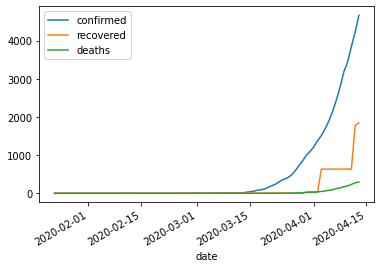

In [145]:
mx.plot()

## Playground (as usual)

In [146]:
#session = Session()

In [147]:
# test = Country(name='test', short_name='t', nickname='tt')
# session.add(test)
# session.commit()

In [58]:
session = Session()
t = session.query(Country).filter(Country.name.like("t%"))
t.all()
#session.commit()

[<Country(name='Taiwan', short_name='None', nickname='None')>,
 <Country(name='Thailand', short_name='None', nickname='None')>]

In [59]:
print(t.statement, list(t.values()))

SELECT country_table.id, country_table.name, country_table.short_name, country_table.nickname 
FROM country_table 
WHERE country_table.name LIKE :name_1 []


In [ ]:
# t.all()

In [ ]:
data = pd.read_csv("{}/01-23-2020.csv".format(data_dir))
data[data['Country/Region'] == 'Mexico']

In [162]:
from sqlalchemy import func
session = Session()

state = "Texas"
q = session.query(DailyData.date,
    func.sum(DailyData.confirmed).label('confirmed'),
    func.sum(DailyData.recovered).label('recovered'),
    func.sum(DailyData.deaths).label('deaths')
                 ).join(State).filter(State.name== state).group_by(DailyData.date)
mx = pd.read_sql(q.statement, q.session.bind, index_col='date', parse_dates="date")
mx = mx.sort_index()
mx.tail()

,confirmed,recovered,deaths
date,,,
2020-04-10,12105,0,238
2020-04-11,13023,0,266
2020-04-12,13677,0,283
2020-04-13,14275,0,305
2020-04-14,15006,0,342


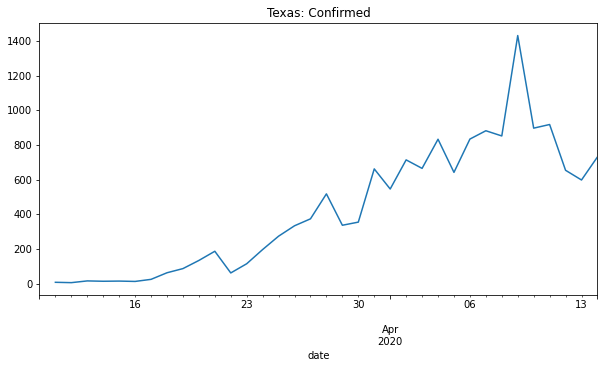

In [163]:
mx["confirmed"].diff().plot(figsize=(10,5), title='{}: Confirmed'.format(state))

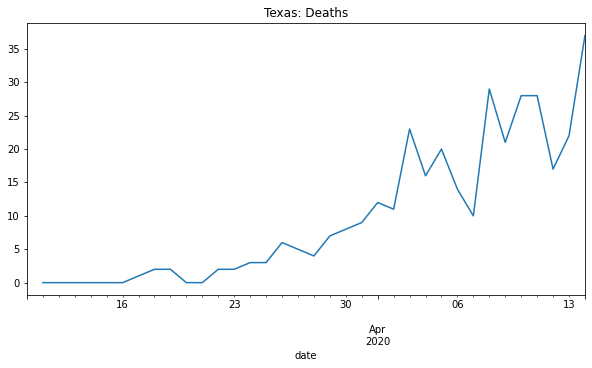

In [165]:
mx["deaths"].diff().plot(figsize=(10,5), title='{}: Deaths'.format(state))

In [105]:
641/22795*100

2.8120201798640054

In [107]:
9385/189033*100

4.96474160596298

In [184]:
from sqlalchemy import func
session = Session()

city = "San Antonio"
state = "Texas"
q = session.query(DailyData.date,
    func.sum(DailyData.confirmed).label('confirmed'),
    func.sum(DailyData.recovered).label('recovered'),
    func.sum(DailyData.deaths).label('deaths')).join(City).\
    filter(City.name== city).\
    group_by(DailyData.date)
mx = pd.read_sql(q.statement, q.session.bind, index_col='date', parse_dates="date")
mx = mx.sort_index()
mx.tail()

,confirmed,recovered,deaths
date,,,
